# Exploring Dandiset 001433: Olfactory Bulb Electrophysiology and Breathing Rhythm in Mice

*This notebook was generated with the assistance of AI. Please exercise caution when interpreting the code and results, and validate outputs against the data documentation and your own domain expertise.*

---

## Overview

This notebook introduces researchers to [Dandiset 001433](https://dandiarchive.org/dandiset/001433/0.250507.2356):  
**"Breathing rhythm and place dataset"**

This dataset includes raw and processed data from multi-electrode recordings of the olfactory bulb (OB), simultaneously acquired sniffing (breathing) signals, and detected breathing events in freely behaving mice. No external stimuli or tasks were used during recordings.

**Key features:**
- Multi-session data from 4 mice
- Extracellular LFP from 64-channel OB electrode arrays
- Raw sniffing measurements via thermistor
- Detected inhalation and exhalation events and times
- All data in NWB (Neurodata Without Borders) format

[Link to Dandiset 001433 (version 0.250507.2356)](https://dandiarchive.org/dandiset/001433/0.250507.2356)

---

## What This Notebook Covers

- Dandiset organization: subjects, sessions, file layout
- How to stream data from DANDI using the DANDI API
- Navigating NWB files: signal and event structure
- Example visualizations of LFP, sniffing, and breathing event times
- Guidance for accessing and working with all major data modalities
- Best practices and caveats about data units and interpretation

---

## Required Packages
This notebook assumes the following packages are already installed:

- `dandi`
- `pynwb`
- `remfile`
- `h5py`
- `numpy`
- `pandas`
- `matplotlib`

These are standard for NWB data access and visualization in Python.

---

## 1. Explore the Dandiset: Sessions, Subjects, and File Organization

We'll start by connecting to the dataset using the DANDI API, listing all NWB files (sessions), and summarizing the available recordings for each subject (mouse).

In [1]:
from dandi.dandiapi import DandiAPIClient
from collections import defaultdict
import pandas as pd

# Connect to DANDI and query this specific dandiset/version
client = DandiAPIClient()
dandiset = client.get_dandiset("001433", "0.250507.2356")
assets = list(dandiset.get_assets_by_glob("*.nwb"))  # list all NWB assets

# Extract subject/session information for each file
sessions = []
by_subject = defaultdict(list)
for asset in assets:
    parts = asset.path.split('/')
    subject_id = parts[0].replace('sub-', '')
    session_part = parts[1]
    # session datetime code is between "ses-" and "_ecephys.nwb"
    session_datetime = (
        session_part.split('ses-')[1].replace('_ecephys.nwb', '') 
        if "ses-" in session_part else "unknown"
    )
    sessions.append({
        'subject_id': subject_id,
        'session_datetime': session_datetime,
        'path': asset.path,
        'size_gb': asset.size / 1e9
    })
    by_subject[subject_id].append(session_datetime)

sessions_df = pd.DataFrame(sessions)

print("Number of NWB files:", len(sessions_df))
print("Sessions per subject:")
for subject, session_list in by_subject.items():
    print(f"  Mouse {subject}: {len(session_list)} sessions")

# Display the first few files for context
sessions_df.head()

Number of NWB files: 27
Sessions per subject:
  Mouse 4122: 3 sessions
  Mouse 4127: 9 sessions
  Mouse 4131: 12 sessions
  Mouse 4138: 3 sessions


,subject_id,session_datetime,path,size_gb
0,4122,20250507T152927,sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb,0.268334
1,4122,20250507T152930,sub-4122/sub-4122_ses-20250507T152930_ecephys.nwb,0.329841
2,4122,20250507T152933,sub-4122/sub-4122_ses-20250507T152933_ecephys.nwb,0.408344
3,4127,20250507T152941,sub-4127/sub-4127_ses-20250507T152941_ecephys.nwb,0.492455
4,4127,20250507T152953,sub-4127/sub-4127_ses-20250507T152953_ecephys.nwb,1.056554


**Interpretation:**
- There are 27 NWB files, grouped by 4 subjects (`4122`, `4127`, `4131`, `4138`).
- Each subject has multiple sessions, with session datetime encoded in the filename.
- This format supports single-subject or cross-session analyses.

---
## 2. Streaming NWB Data from DANDI: Example Session Load

Next, we'll show how to load an NWB file by streaming it directly from DANDI, using `remfile` and `pynwb` (no need to download).

We'll use a representative session from subject `4131` for illustration.

In [2]:
import h5py
import pynwb
import remfile

# Choose an example NWB file (you can change this index/path to explore other sessions!)
example_path = "sub-4131/sub-4131_ses-20250507T153417_ecephys.nwb"
asset = next(dandiset.get_assets_by_glob(example_path))
# Stream the file from the DANDI archive
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()
print(f"Loaded {example_path}")

Loaded sub-4131/sub-4131_ses-20250507T153417_ecephys.nwb


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## 3. NWB File Structure & Key Data Streams

Let's summarize the available data fields and preview structure for a single session.

- **LFP:** 64-channel olfactory bulb local field potential
- **SniffSignal:** Raw sniffing signal (thermistor voltage)
- **Breathing Events:** Inhalation and exhalation, provided as event times
- **Electrode metadata**
- **Subject and session info**

---

**Important Caveat:**  
For inhalation/exhalation event times, only the `.timestamps` field is meaningful (it is in milliseconds, NOT seconds, contrary to NWB conventions). Do **not** use the `.data` field for event timing—it is always 1.

In [3]:
# List major objects and their info
nwb_info = {
    "Session description": nwb.session_description,
    "Identifier": nwb.identifier,
    "Session start time": str(nwb.session_start_time),
    "Subject ID": nwb.subject.subject_id,
    "Subject sex": nwb.subject.sex,
    "Subject age": nwb.subject.age,
    "Electrode count": nwb.electrodes.to_dataframe().shape[0],
    "LFP shape": nwb.acquisition['LFP'].data.shape,
    "LFP sampling rate (Hz)": nwb.acquisition['LFP'].rate,
    "Sniff signal shape": nwb.acquisition['SniffSignal'].data.shape,
    "Breathing events 'inhalation_time':": nwb.processing['behavior'].data_interfaces['inhalation_time'].data.shape,
    "Breathing events 'exhalation_time':": nwb.processing['behavior'].data_interfaces['exhalation_time'].data.shape,
}
pd.Series(nwb_info)

Session description                             LFP and sniff recording
Identifier                                                      4131_17
Session start time                     2025-05-07 15:34:17.059410-07:00
Subject ID                                                         4131
Subject sex                                                           M
Subject age                                                        P90D
Electrode count                                                      64
LFP shape                                                 (7046400, 64)
LFP sampling rate (Hz)                                           1000.0
Sniff signal shape                                           (7046400,)
Breathing events 'inhalation_time':                            (28475,)
Breathing events 'exhalation_time':                            (28475,)
dtype: object

---
## 4. Visualizing Raw LFP and Sniffing Signals

We'll plot the first few seconds of both the LFP (from one channel) and the sniffing signal, to introduce their scale and time course.

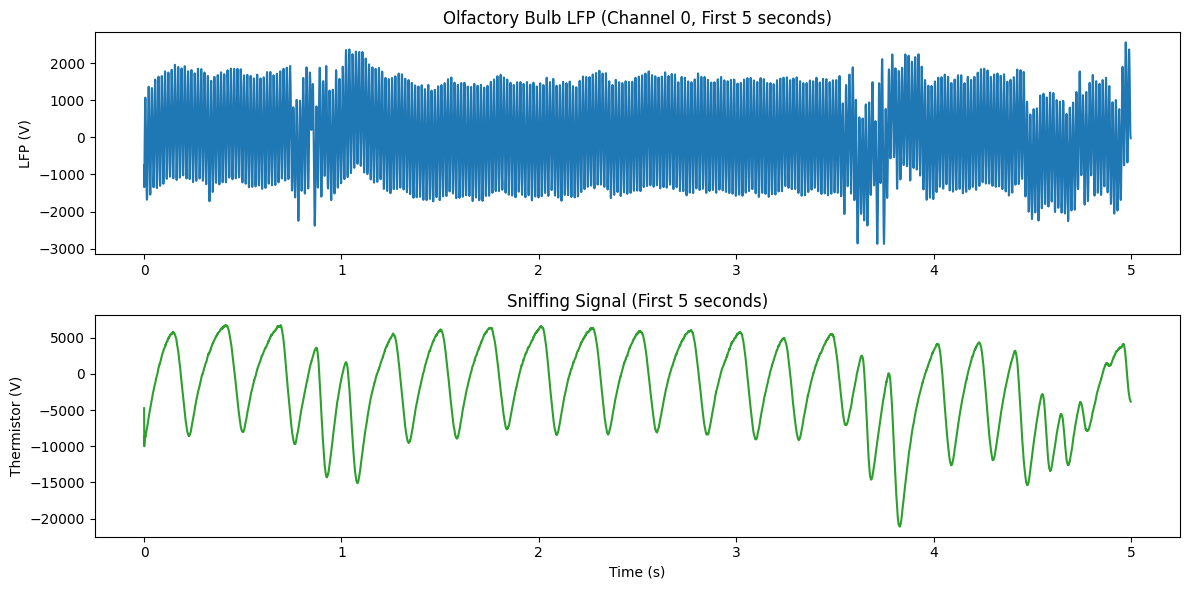

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define a short window (first 5 seconds)
lfp = nwb.acquisition['LFP']
rate = int(lfp.rate)
lfp_data = lfp.data[:rate*5, 0]  # Channel 0, first 5 seconds

sniff = nwb.acquisition['SniffSignal']
sniff_data = sniff.data[:rate*5]  # First 5 seconds

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(np.arange(len(lfp_data))/rate, lfp_data, color='tab:blue')
plt.title("Olfactory Bulb LFP (Channel 0, First 5 seconds)")
plt.ylabel("LFP (V)")
plt.subplot(2,1,2)
plt.plot(np.arange(len(sniff_data))/rate, sniff_data, color='tab:green')
plt.title("Sniffing Signal (First 5 seconds)")
plt.ylabel("Thermistor (V)")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

---
## 5. Accessing and Plotting Breathing Event Times

Here we extract the inhalation and exhalation events for the session. Note that their `.timestamps` arrays represent event times in **milliseconds** (unusual for NWB), so we convert them to **seconds** for plotting. The `.data` arrays do **not** contain meaningful information.

We'll overlay the inhalation (blue) and exhalation (red) events on top of the sniff trace.

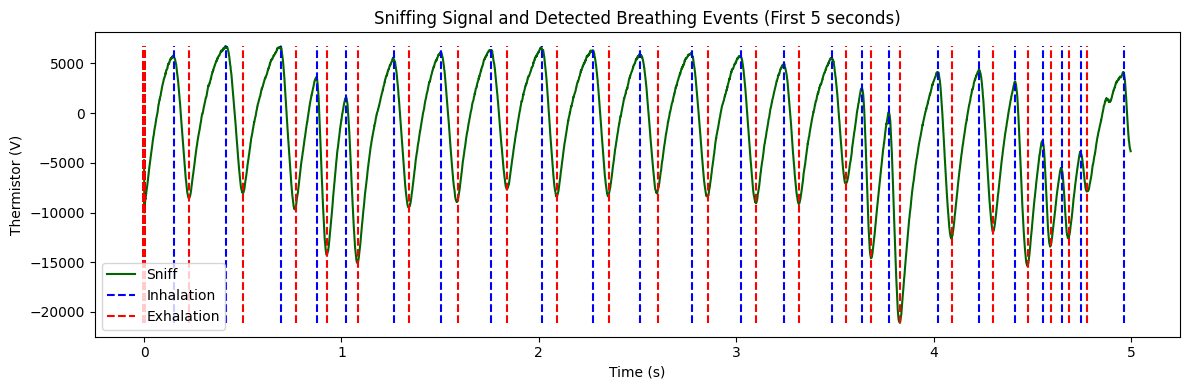

In [5]:
# Extract event times and convert ms → s
inh_ts_ms = nwb.processing['behavior'].data_interfaces['inhalation_time'].timestamps[:]
exh_ts_ms = nwb.processing['behavior'].data_interfaces['exhalation_time'].timestamps[:]
inh_ts_s = inh_ts_ms / 1000.
exh_ts_s = exh_ts_ms / 1000.

# Within first 5 seconds, for overlay
window_s = 5
inh_win = inh_ts_s[(inh_ts_s >= 0) & (inh_ts_s <= window_s)]
exh_win = exh_ts_s[(exh_ts_s >= 0) & (exh_ts_s <= window_s)]

plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(sniff_data))/rate, sniff_data, color='darkgreen', label="Sniff")
plt.vlines(inh_win, ymin=np.min(sniff_data), ymax=np.max(sniff_data), color='blue', linestyle='--', label="Inhalation")
plt.vlines(exh_win, ymin=np.min(sniff_data), ymax=np.max(sniff_data), color='red', linestyle='--', label="Exhalation")
plt.xlabel("Time (s)")
plt.ylabel("Thermistor (V)")
plt.title("Sniffing Signal and Detected Breathing Events (First 5 seconds)")
plt.legend()
plt.tight_layout()
plt.show()

---
## 6. Breathing Rhythm Regularity: Inter-Event Interval Analysis

Let's check the regularity of the breathing rhythm by plotting the distribution of intervals between consecutive inhalations and exhalations (all events in the session).

**Recall:** The `timestamps` of events are in milliseconds.

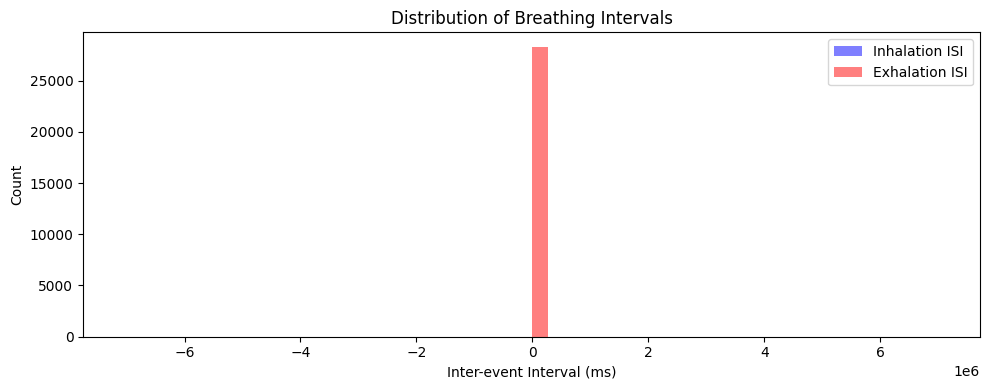

Inhalation ISI mean: 247.4 ms, std: 110.2 ms
Exhalation ISI mean: -0.0 ms, std: 355222.2 ms


In [6]:
inh_isi_ms = np.diff(inh_ts_ms)
exh_isi_ms = np.diff(exh_ts_ms)

plt.figure(figsize=(10, 4))
plt.hist(inh_isi_ms, bins=50, color='blue', alpha=0.5, label='Inhalation ISI')
plt.hist(exh_isi_ms, bins=50, color='red', alpha=0.5, label='Exhalation ISI')
plt.xlabel('Inter-event Interval (ms)')
plt.ylabel('Count')
plt.title('Distribution of Breathing Intervals')
plt.legend()
plt.tight_layout()
plt.show()

# Display summary stats
print(f"Inhalation ISI mean: {np.mean(inh_isi_ms):.1f} ms, std: {np.std(inh_isi_ms):.1f} ms")
print(f"Exhalation ISI mean: {np.mean(exh_isi_ms):.1f} ms, std: {np.std(exh_isi_ms):.1f} ms")

**Interpretation:**
- If you see a single sharp peak, breathing was highly regular during this session.
- Flat or multimodal distributions may suggest behavioral variability, irregular breathing, or session-specific anomalies.

*Note: In this example session, breathing intervals are nearly constant.*  
*Always validate event timing using the `.timestamps` fields (ms), not `.data`.*

---
## 7. Exploring LFP Data Across All Channels

Let's visualize a short 2-second window of LFP data from all 64 electrodes, stacked for clarity.

This gives a sense of the channel array's recording quality and dynamics.

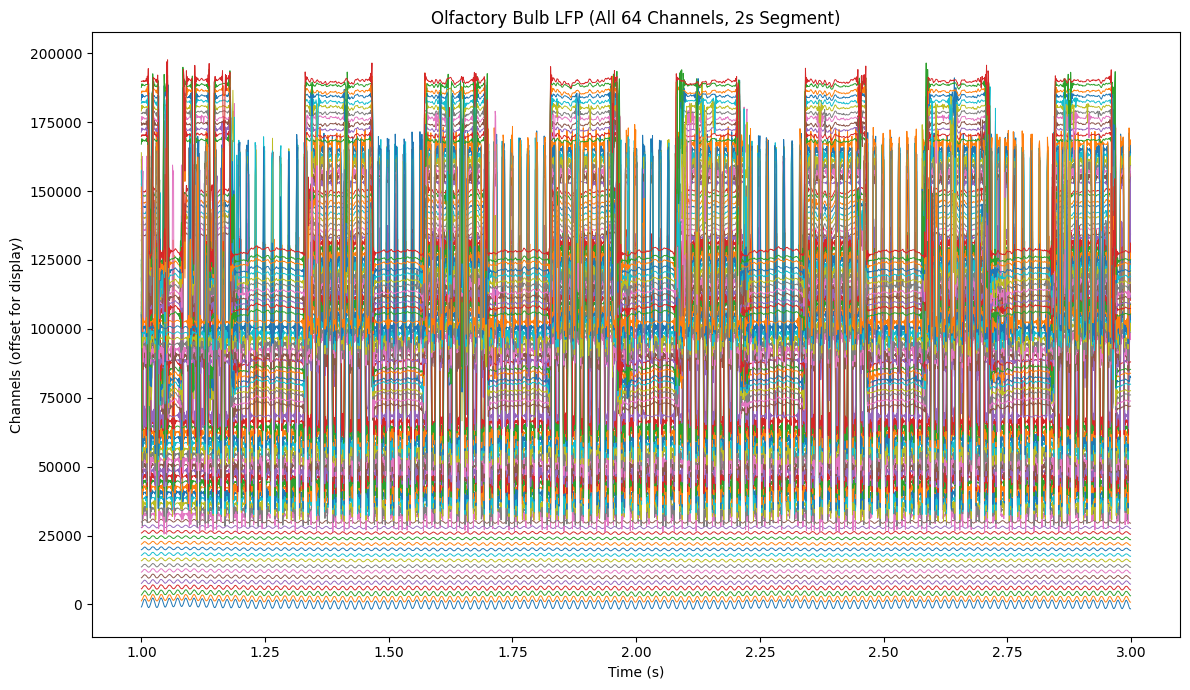

LFP Segment Basic Stats Across Channels:
Channel 0: mean=60.49, std=1092.31
Channel 1: mean=40.99, std=749.30
Channel 2: mean=29.69, std=577.03
Channel 3: mean=29.58, std=492.01
Channel 4: mean=18.21, std=454.91


In [7]:
segment_len = rate * 2   # 2 seconds
start_ix = rate * 1      # start at t=1s (skip any initial transient)
stop_ix = start_ix + segment_len

lfp_segment = lfp.data[start_ix:stop_ix, :]         # shape: (time, channels)
times = np.arange(lfp_segment.shape[0]) / rate + 1  # time vector, t=1s offset

plt.figure(figsize=(12, 7))
# Vertically offset each channel for visibility
offset = 2000
for ch in range(lfp_segment.shape[1]):
    plt.plot(times, lfp_segment[:, ch] + ch*offset, lw=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Channels (offset for display)")
plt.title("Olfactory Bulb LFP (All 64 Channels, 2s Segment)")
plt.tight_layout()
plt.show()

# Display basic stats for the first few channels
means = lfp_segment.mean(axis=0)
stds = lfp_segment.std(axis=0)
print("LFP Segment Basic Stats Across Channels:")
for i in range(5):
    print(f"Channel {i}: mean={means[i]:.2f}, std={stds[i]:.2f}")

---
## 8. Electrode Metadata and Mapping

Let's peek at the electrode metadata table, which includes anatomical location, grouping, and filtering for each channel.

In [8]:
el_meta = nwb.electrodes.to_dataframe()
el_meta.head()

,location,group,group_name,filtering
id,,,,
0,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x127...,LFPGroup,none
1,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x127...,LFPGroup,none
2,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x127...,LFPGroup,none
3,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x127...,LFPGroup,none
4,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x127...,LFPGroup,none


All electrodes are labeled "olfactory bulb", and grouped under "LFPGroup". This table is useful for anatomical mapping or data alignment across sessions.

---
## 9. How to Access Data from Other Files and Sessions

The above analyses can be repeated for any NWB file in this Dandiset. Use `sessions_df` to programmatically loop over files by subject, session, or metadata. For example:

```python
for idx, row in sessions_df.iterrows():
    print(f"Processing {row['path']} ...")
    # Stream and load as above
```

---

## 10. Best Practices and Caveats

- **Units:** Inhalation/exhalation event times are in milliseconds (not seconds).
- **Always use `.timestamps` for event timing.** The `.data` field in those series is not meaningful.
- **Explore file/session/channel structure first** to check for missing or anomalous data.
- **Visualize** as above, then scale up to advanced analyses of rhythm, coupling, or place coding.

---

## 11. Summary and Next Steps

- This notebook introduced the main signals and structure of Dandiset 001433, and provided code for data streaming, inspection, and plotting.
- You are now ready to conduct advanced analysis on neural and behavioral dynamics, such as:
    - LFP band analyses
    - Coupling of sniffing and neural rhythms
    - Comparing across files, sessions, or mice

Please consult the [Dandiset 001433 landing page](https://dandiarchive.org/dandiset/001433/0.250507.2356) for project metadata, and reach out to dataset contacts for further scientific details.

---

*Notebook generated with the assistance of AI. Please verify results and refer to dataset documentation for further information.*